In [1]:
# 必要なライブラリのインポート
import cv2
import numpy as np
import os
from tqdm import tqdm
from sklearn import svm
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score
import matplotlib.pyplot as plt
import joblib

In [2]:
# データの準備
def load_images_from_folder(folder, max_images=500):
    images = []
    count = 0
    for filename in tqdm(os.listdir(folder), desc=f"Loading images from {folder}"):
        if count >= max_images:
            break
        img = cv2.imread(os.path.join(folder, filename))
        if img is not None:
            img = cv2.resize(img, (64, 128))  # 画像サイズを統一
            images.append(img)
            count += 1
    return images

def extract_hog_features(image):
    winSize = (64, 128)
    blockSize = (16, 16)
    blockStride = (8, 8)
    cellSize = (8, 8)
    nbins = 9
    derivAperture = 1
    winSigma = 4.0
    histogramNormType = 0
    L2HysThreshold = 2.0000000000000001e-01
    gammaCorrection = 0
    nlevels = 64
    hog = cv2.HOGDescriptor(winSize, blockSize, blockStride, cellSize, nbins, derivAperture, winSigma, 
                            histogramNormType, L2HysThreshold, gammaCorrection, nlevels)
    h = hog.compute(image)
    return h

def prepare_data(positive_folder, negative_folder, max_images=500):
    positive_images = load_images_from_folder(positive_folder, max_images)
    negative_images = load_images_from_folder(negative_folder, max_images)

    X = []
    y = []

    for img in tqdm(positive_images, desc="Extracting features from positive images"):
        features = extract_hog_features(img)
        X.append(features)
        y.append(1)  # ポジティブラベル

    for img in tqdm(negative_images, desc="Extracting features from negative images"):
        features = extract_hog_features(img)
        X.append(features)
        y.append(0)  # ネガティブラベル

    X = np.array(X).reshape(len(X), -1)
    y = np.array(y)
    
    # データをシャッフル
    X, y = shuffle(X, y)
    
    return X, y

# データセットの準備
positive_folder = "dataset/positive"
negative_folder = "dataset/negative"
X, y = prepare_data(positive_folder, negative_folder, max_images=500)

# データセットを訓練用とテスト用に分割
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


Extracting features from negative images: 100%|██████████| 500/500 [00:00<00:00, 1780.03it/s]


In [3]:
# SVMモデルの訓練

# SVMモデルの定義と訓練
model = svm.SVC(kernel='rbf', gamma=8e-3)
model.fit(X_train, y_train)

# モデルの評価
y_pred = model.predict(X_test)
print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

# モデルの保存
joblib.dump(model, 'hog_svm_model_notebook2.pkl')


Accuracy: 1.0
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        95
           1       1.00      1.00      1.00       105

    accuracy                           1.00       200
   macro avg       1.00      1.00      1.00       200
weighted avg       1.00      1.00      1.00       200



In [4]:
def pyramid(image, scale=1.5, min_size=(30, 30)):
    yield image
    while True:
        w = int(image.shape[1] / scale)
        image = cv2.resize(image, (w, w))
        if image.shape[0] < min_size[1] or image.shape[1] < min_size[0]:
            break
        yield image

def sliding_window(image, step_size, window_size):
    for y in range(0, image.shape[0], step_size):
        for x in range(0, image.shape[1], step_size):
            yield (x, y, image[y:y + window_size[1], x:x + window_size[0]])

def detect_human_multiscale(image, model, window_size=(64, 128), step_size=4, scale=1.05):
    detections = []
    for resized in tqdm(pyramid(image, scale=scale), desc="Processing image pyramid"):
        scale_factor = image.shape[0] / float(resized.shape[0])
        for (x, y, window) in sliding_window(resized, step_size=step_size, window_size=window_size):
            if window.shape[0] != window_size[1] or window.shape[1] != window_size[0]:
                continue

            features = extract_hog_features(window)
            features = features.reshape(1, -1)
            prediction = model.predict(features)

            if prediction == 1:
                x1 = int(x * scale_factor)
                y1 = int(y * scale_factor)
                x2 = int((x + window_size[0]) * scale_factor)
                y2 = int((y + window_size[1]) * scale_factor)
                detections.append((x1, y1, x2, y2))

    return np.array(detections)

def non_max_suppression(boxes, overlapThresh=0.5):
    if len(boxes) == 0:
        return []

    if boxes.dtype.kind == "i":
        boxes = boxes.astype("float")

    pick = []

    x1 = boxes[:,0]
    y1 = boxes[:,1]
    x2 = boxes[:,2]
    y2 = boxes[:,3]

    area = (x2 - x1 + 1) * (y2 - y1 + 1)
    idxs = np.argsort(y2)

    while len(idxs) > 0:
        last = len(idxs) - 1
        i = idxs[last]
        pick.append(i)

        xx1 = np.maximum(x1[i], x1[idxs[:last]])
        yy1 = np.maximum(y1[i], y1[idxs[:last]])
        xx2 = np.minimum(x2[i], x2[idxs[:last]])
        yy2 = np.minimum(y2[i], y2[idxs[:last]])

        w = np.maximum(0, xx2 - xx1 + 1)
        h = np.maximum(0, yy2 - yy1 + 1)

        overlap = (w * h) / area[idxs[:last]]

        idxs = np.delete(idxs, np.concatenate(([last], np.where(overlap > overlapThresh)[0])))

    return boxes[pick].astype("int")

Processing image pyramid: 44it [00:36,  1.20it/s]


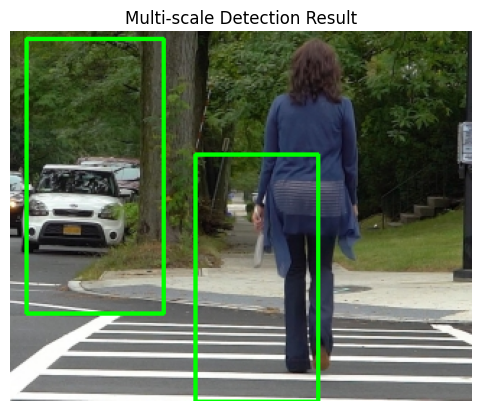

In [8]:
# テスト画像の読み込み
test_image_path = "pedestrain.png"
test_image = cv2.imread(test_image_path)

# 複数のスケールで人を検出
detections = detect_human_multiscale(test_image, model)

# 非極大抑制を適用
final_detections = non_max_suppression(detections, overlapThresh=0.3)

# 検出結果を描画
for (x1, y1, x2, y2) in final_detections:
    cv2.rectangle(test_image, (x1, y1), (x2, y2), (0, 255, 0), 2)

# 結果を表示
plt.imshow(cv2.cvtColor(test_image, cv2.COLOR_BGR2RGB))
plt.title("Multi-scale Detection Result")
plt.axis("off")
plt.show()

Processing image pyramid: 49it [01:11,  1.47s/it]


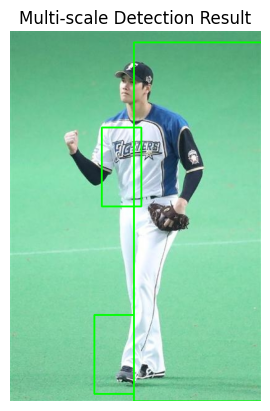

In [7]:
# テスト画像の読み込み
test_image_path = "Ohtani-san.jpg"
test_image = cv2.imread(test_image_path)

# 複数のスケールで人を検出
detections = detect_human_multiscale(test_image, model)

# 非極大抑制を適用
final_detections = non_max_suppression(detections, overlapThresh=0.3)

# 検出結果を描画
for (x1, y1, x2, y2) in final_detections:
    cv2.rectangle(test_image, (x1, y1), (x2, y2), (0, 255, 0), 2)

# 結果を表示
plt.imshow(cv2.cvtColor(test_image, cv2.COLOR_BGR2RGB))
plt.title("Multi-scale Detection Result")
plt.axis("off")
plt.show()

In [ ]:
# 混同行列の可視化
def plot_confusion_matrix(y_test, y_pred):
    cm = confusion_matrix(y_test, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot(cmap=plt.cm.Blues)
    plt.title('Confusion Matrix')
    plt.show()

# ROC曲線のプロット
def plot_roc_curve(y_test, y_pred_prob):
    fpr, tpr, _ = roc_curve(y_test, y_pred_prob)
    roc_auc = auc(fpr, tpr)
    
    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic')
    plt.legend(loc="lower right")
    plt.show()
    
    
# テストデータセットでの評価
y_pred_test = model.predict(X_test)
y_pred_test_prob = model.decision_function(X_test)

# 混同行列のプロット
plot_confusion_matrix(y_test, y_pred_test)

# ROC曲線のプロット
plot_roc_curve(y_test, y_pred_test_prob)
